In [1]:
from ProtMamba_ssm.core import *
from ProtMamba_ssm.dataloaders import *
from ProtMamba_ssm.utils import *
from ProtMamba_ssm.modules import *
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import os

2024-10-01 12:03:19.208536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 12:03:19.223945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 12:03:19.241418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 12:03:19.246784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 12:03:19.260898: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import math

def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    Exponential moving average
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

def find_fim_indices(is_cls_tokens, is_eos_tokens):
    # add a cls token at the beginning
    is_cls_tokens = torch.cat([torch.ones_like(is_cls_tokens[:, :1]), is_cls_tokens], dim=1)
    is_eos_tokens = torch.cat([torch.zeros_like(is_eos_tokens[:, :1]), is_eos_tokens], dim=1)
    # both eos and cls tokens
    bol = is_cls_tokens | is_eos_tokens
    tmp = torch.zeros_like(is_cls_tokens, dtype=torch.int)
    tmp[torch.nonzero(is_cls_tokens, as_tuple=True)] = 1
    tmp[torch.nonzero(is_eos_tokens, as_tuple=True)] = -1
    bol1 = torch.clone(bol)
    for batch_ind in range(tmp.size(0)):
        tmp1 = tmp[batch_ind,bol[batch_ind]]
        # find all positions where a 1 if preceeded by a -1
        tmp1 = tmp1[:-1]*tmp1[1:]
        # add the first element to make the sequence start with a 1
        tmp1 = torch.cat([torch.ones_like(tmp1[:1]).to(tmp1.device), tmp1])
        new_bol = tmp1<0
        # bool array True only in the positions where a 1 is preceeded by a -1
        bol1[batch_ind,bol[batch_ind]] = False if new_bol.size(0) == 0 else new_bol
    cumulative_sum = torch.cumsum(bol1, dim=1)
    # Use modulo operation to get the desired tensor
    bol2 = cumulative_sum % 2 == 1
    bol2[is_eos_tokens]= False
    return bol2[:,1:]


def compute_metrics(predictions, labels, full_fim=False):
    predictions = predictions.permute(0, 2, 1)
    labels = labels
    # shift labels to align them with predictions and remove last prediction to match the length
    predictions = predictions[:, :, :-1].contiguous()
    labels = labels[:, 1:].contiguous()
    # compute unreduced elementwise loss
    unreduced_loss = torch.nn.functional.cross_entropy(predictions, labels, reduction="none")
    # compute reconstruction accuracy
    reconstruction = (predictions.argmax(1) == labels)

    # start and end tokens
    is_cls_tokens = (labels == AA_TO_ID["<cls>"])
    is_eos_tokens = (labels == AA_TO_ID["<eos>"])
    # fill in the middle tokens
    if full_fim:
        print("Using for loop fim")
        fim_tokens = torch.zeros(is_cls_tokens.size(0), is_cls_tokens.size(1), dtype=torch.bool).to(is_cls_tokens.device)
        in_mask_vector = torch.zeros(is_cls_tokens.size(0), dtype=torch.bool).to(is_cls_tokens.device)
        for j in range(is_cls_tokens.size(1)):
            in_mask_vector = in_mask_vector & ~is_cls_tokens[:, j]
            fim_tokens[:, j] = in_mask_vector
            in_mask_vector = in_mask_vector | is_eos_tokens[:, j]
    else:
        fim_tokens = find_fim_indices(is_cls_tokens, is_eos_tokens)

    number_sequences = torch.cumsum(torch.cat([torch.zeros(is_cls_tokens.size(0),1, dtype=torch.int32).to(is_cls_tokens.device), is_cls_tokens[:,:-1]],1), -1)
    # sequence tokens
    sequence_perplexity, sequence_fim_perplexity = [], []
    sequence_loss, sequence_fim_loss = [], []
    sequence_size_fim_part = []
    num_tokens_preceeding = []
    num_tokens = torch.arange(labels.size(1)).to(labels.device)
    num_tokens = torch.cat([num_tokens[None, :] for _ in range(labels.size(0))], dim=0)
    for i in range(torch.max(number_sequences.max(1).values[:, None] - 1).item()):
        i_sequence_tokens = ((~fim_tokens & (labels < 33)) | fim_tokens) & (number_sequences == i)
        i_sequence_tokens_fim = fim_tokens & (number_sequences == i) 
        i_sequence_cls_tokens = is_cls_tokens & (number_sequences == i)
        num_tokens_preceeding.append(num_tokens[i_sequence_cls_tokens])
        sequence_perplexity.append(torch.exp(torch.mean(unreduced_loss[i_sequence_tokens])).item())
        sequence_fim_perplexity.append(torch.exp(torch.mean(unreduced_loss[i_sequence_tokens_fim])).item())
        sequence_loss.append(torch.mean(unreduced_loss[i_sequence_tokens]).item())
        sequence_fim_loss.append(torch.mean(unreduced_loss[i_sequence_tokens_fim]).item())
        tmp1 = i_sequence_tokens_fim & (labels < 33)
        tmp2 = i_sequence_tokens_fim & (labels >= 33)
        sequence_size_fim_part.append((tmp1.sum()/tmp2.sum()).item())
    # metrics
    # cum_loss = torch.cumsum(unreduced_loss, dim=1)/torch.cumsum(torch.ones_like(unreduced_loss), dim=1)
    return {"loss": unreduced_loss,
            "sequence_losses": torch.tensor(sequence_loss),
            "sequence_perplexities": torch.tensor(sequence_perplexity),
            "sequence_fim_losses": torch.tensor(sequence_fim_loss),
            "sequence_fim_perplexities": torch.tensor(sequence_fim_perplexity),
            "sequence_size_fim_part": torch.tensor(sequence_size_fim_part),
            "reconstruction": reconstruction,
            "num_tokens_preceeding": torch.tensor(num_tokens_preceeding),
            }

## Perplexity

In [3]:
is_fim = True
dataset_name = "encoded_MSAs_test.pkl"
fim_strategy = "multiple_span" if is_fim else "no-scramble"
# Load dataset
dataset = Uniclust30_Dataset(dataset_name,
                             filepath="/nvme1/common/OpenProteinSet/",
                             max_msa_len=135000,
                             sample=False,
                             max_patches=1,
                             mask_fraction=0.1,
                             fim_strategy=fim_strategy,
                             max_position_embeddings=2048,
                             add_position_ids="1d")
device = "cuda"
# Load pretrained model
model = load_model("/nvme1/common/mamba_100M_FIM-finetuned_131k_checkpoint-3200",
                   model_class=MambaLMHeadModelwithPosids,
                   device=device,
                   dtype=torch.bfloat16,
                   checkpoint_mixer=False)
model.eval()
# model = torch.compile(model)
# data_collator = DataCollatorForUniclust30Dataset()

Using a model that was pretrained with gradient checkpointing but now do not want to use it. Changed the keys of the state_dict to match the model's keys.


MambaLMHeadModelwithPosids(
  (backbone): MixerModelWithPosids(
    (embedding): Embedding(40, 512)
    (position_embedding): Embedding(2048, 512)
    (layers): ModuleList(
      (0-15): 16 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (act): SiLU()
          (x_proj): Linear(in_features=2048, out_features=96, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=1024, out_features=40, bias=False)
)

In [4]:
# histogram of length sequences in dataset
lengths = []
for i in range(len(dataset)):
    data = dataset[i]["input_ids"]
    start = dataset.get_index_start_of_sequences(dataset[i]["input_ids"])
    lengths.append(np.mean(start[1:] - start[:-1]))

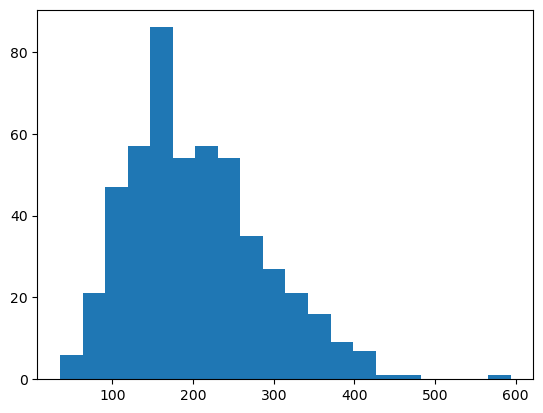

In [5]:
plt.hist(lengths, bins=20)
plt.show()

In [6]:
what = input("How should the files be named?:") # "0.05-135k_new"
loss = []
# reconstruction = []
seq_size_fim_part = []
seq_loss, seq_perp = [], []
seq_fim_loss, seq_fim_perp = [], []
num_tokens_preceeding = []
with torch.no_grad():
    for i in tqdm(range(len(dataset))):
        for j in range(100):
            data = dataset[i]#data_collator([dataset[i] for j in range(4)])
            tokens = data["input_ids"][None,:].to(device)
            pos_ids = data["position_ids"][None,:].to(device)
            # tokens = data["input_ids"].to(device)
            # pos_ids = data["position_ids"].to(device)
            out = model(tokens, pos_ids)
            logits = out.logits
            metrics = compute_metrics(logits, tokens)
            loss += [metrics["loss"].cpu().to(torch.float).numpy()]
            # reconstruction += [metrics["reconstruction"].cpu().to(torch.float).numpy()]
            # cum_loss += [metrics["cumulative_loss"][0].cpu().to(torch.float).numpy()]
            # cum_perp += [metrics["cumulative_perplexity"][0].cpu().to(torch.float).numpy()]
            # cum_rec += [metrics["cumulative_reconstruction"][0].cpu().to(torch.float).numpy()]
            seq_loss.append(metrics["sequence_losses"])
            seq_perp.append(metrics["sequence_perplexities"])
            seq_fim_loss.append(metrics["sequence_fim_losses"])
            seq_fim_perp.append(metrics["sequence_fim_perplexities"])
            seq_size_fim_part.append(metrics["sequence_size_fim_part"])
            num_tokens_preceeding.append(metrics["num_tokens_preceeding"])

How should the files be named?: test


  1%|          | 3/500 [07:43<21:19:51, 154.51s/it]


KeyboardInterrupt: 

In [46]:
logits.max(2)

torch.return_types.max(
values=tensor([[  2.0312,  -1.0234,  -6.9375,  ..., -13.2500, -10.5000,  22.8750]],
       device='cuda:0', dtype=torch.bfloat16),
indices=tensor([[20,  4,  4,  ...,  8,  2, 33]], device='cuda:0'))

In [48]:
metrics

{'loss': tensor([[2.6562, 3.0156, 2.8125,  ..., 0.2871, 1.7266, 1.1641]],
        device='cuda:0', dtype=torch.bfloat16),
 'sequence_losses': tensor([2.2656, 2.2500, 2.0469,  ..., 2.2188, 2.7188, 1.8828]),
 'sequence_perplexities': tensor([ 9.6250,  9.5000,  7.7500,  ...,  9.1875, 15.1875,  6.5625]),
 'sequence_fim_losses': tensor([   nan,    nan,    nan,  ..., 1.4688, 1.6094, 1.0781]),
 'sequence_fim_perplexities': tensor([   nan,    nan,    nan,  ..., 4.3438, 5.0000, 2.9375]),
 'sequence_size_fim_part': tensor([nan, nan, nan,  ..., 5., 1., 1.]),
 'reconstruction': tensor([[False, False, False,  ...,  True,  True,  True]], device='cuda:0'),
 'num_tokens_preceeding': tensor([    94,    176,    297,  ..., 134532, 134734, 134806])}

In [40]:
torch.stack([tokens[0, idx-10: idx+10], pos_ids[0, idx-10: idx+10]], 0).t()

tensor([[ 13, 106],
        [ 14, 107],
        [ 22, 108],
        [ 19, 109],
        [ 18, 110],
        [  4, 111],
        [  5, 112],
        [ 20, 113],
        [  5, 114],
        [  2,   0],
        [ 33,  27],
        [  8,  27],
        [ 10,  28],
        [ 12,  29],
        [  0,   0],
        [  5,   1],
        [ 22,   2],
        [ 10,   3],
        [ 11,   4],
        [  4,   5]], device='cuda:0')

In [ ]:
dict_seq_loss, dict_seq_perp = {}, {}
dict_seq_length, dict_seq_fim_length = {}, {}
dict_seq_fim_loss, dict_seq_fim_perp = {}, {}
dict_size_fim = {}
ctx_lengths = [1024,2048,4096,8192,16384,32768,65536,131072,262144]
dict_ctx_perp, dict_ctx_fim_perp = {l_ctx: [] for l_ctx in ctx_lengths}, {l_ctx: [] for l_ctx in ctx_lengths}
dict_ctx_lenghts = {l_ctx: [] for l_ctx in ctx_lengths}
dict_ctx_len, dict_ctx_fim_len = {l_ctx: [] for l_ctx in ctx_lengths}, {l_ctx: [] for l_ctx in ctx_lengths}
for el in zip(seq_loss, seq_perp, seq_fim_loss, seq_fim_perp, seq_size_fim_part, num_tokens_preceeding):
    avg_l = (el[5][-1]/len(el[5])).item()
    for i in range(len(el[0])):
        if i in dict_seq_loss:
            dict_seq_loss[i].append(el[0][i].item())
            dict_seq_perp[i].append(el[1][i].item())
            dict_seq_length[i].append(avg_l)
        else:
            dict_seq_perp[i] = [el[1][i].item()]
            dict_seq_loss[i] = [el[0][i].item()]
            dict_seq_length[i] = [avg_l]
    for i in range(len(el[2])):
        if i in dict_seq_fim_loss:
            if el[2][i] >0:
                dict_seq_fim_loss[i].append(el[2][i].item())
                dict_seq_fim_length[i].append(avg_l)
            if el[3][i]  >0:
                dict_seq_fim_perp[i].append(el[3][i].item())
            if el[4][i] >0:
                dict_size_fim[i].append(el[4][i].item())
        else:
            if el[2][i] >0:
                dict_seq_fim_loss[i] = [el[2][i].item()]
                dict_seq_fim_length[i] = [avg_l]
            if el[3][i] >0:
                dict_seq_fim_perp[i] = [el[3][i].item()]
            if el[4][i] >0:
                dict_size_fim[i] = [el[4][i].item()]
    # context legths
    for l_ctx in ctx_lengths:
        if el[5][-1].item() > l_ctx and el[5][0].item() < l_ctx:
            indx = torch.argwhere(el[5]<=l_ctx)[-1]
            dict_ctx_lenghts[l_ctx].append(el[5][indx].item())
            dict_ctx_perp[l_ctx].append(el[1][indx].item())
            dict_ctx_len[l_ctx].append(avg_l)
            if el[3][indx] > 0:
                dict_ctx_fim_perp[l_ctx].append(el[3][indx].item())
                dict_ctx_fim_len[l_ctx].append(avg_l)

In [ ]:
os.makedirs(f"figures/{what}", exist_ok=True)

with open(f"figures/{what}/dict_seq_loss_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_loss, f)
with open(f"figures/{what}/dict_seq_perp_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_perp, f)
with open(f"figures/{what}/dict_seq_fim_loss_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_fim_loss, f)
with open(f"figures/{what}/dict_seq_fim_perp_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_fim_perp, f)
with open(f"figures/{what}/dict_size_fim_all_test.pkl", "wb") as f:
    pickle.dump(dict_size_fim, f)
with open(f"figures/{what}/dict_ctx_lengths_all_test.pkl", "wb") as f:
    pickle.dump(dict_ctx_lenghts, f)
with open(f"figures/{what}/dict_ctx_perp_all_test.pkl", "wb") as f:
    pickle.dump(dict_ctx_perp, f)
with open(f"figures/{what}/dict_ctx_fim_perp_all_test.pkl", "wb") as f:
    pickle.dump(dict_ctx_fim_perp, f)
with open(f"figures/{what}/dict_seq_length_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_length, f)
with open(f"figures/{what}/dict_seq_fim_length_all_test.pkl", "wb") as f:
    pickle.dump(dict_seq_fim_length, f)
with open(f"figures/{what}/dict_ctx_len_all_test.pkl", "wb") as f:
    pickle.dump(dict_ctx_len, f)
with open(f"figures/{what}/dict_ctx_fim_len_all_test.pkl", "wb") as f:
    pickle.dump(dict_ctx_fim_len, f)

## Figures

In [ ]:
import seaborn as sns

sns.set_theme(
    context='notebook', style='ticks', palette='bright',
    color_codes=True)  #other contexts: “paper”, “talk”, and “poster”,

# Plotting settings
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif", #sans-serif
    "font.serif": ["Arial"],
    "font.size": MEDIUM_SIZE,
    "axes.titlesize": MEDIUM_SIZE,
    "axes.labelsize": MEDIUM_SIZE,
    "figure.titlesize": MEDIUM_SIZE,
    "figure.labelsize": MEDIUM_SIZE,
    "xtick.labelsize": SMALL_SIZE,
    "ytick.labelsize": SMALL_SIZE,
    "legend.fontsize": MEDIUM_SIZE,
})

color_ = [(64, 83, 211), (0, 178, 93), (181, 29, 20), (221, 179, 16), (0, 190, 255), (251, 73, 176), (202, 202, 202)]
color =[]
for t in color_:
    color.append(tuple(ti/255 for ti in t))
    
# split a dictionary based on the length of the sequences
def split_lengths(dic, lengths, L=[100, 200]):
    new_dic = {ll: {j: [] for j in dic.keys()} for ll in L+[-1]}
    for j in dic.keys():
        lst = dic[j]
        lst_l = lengths[j]
        for i in range(len(lst)):
            for ll in L:
                if lst_l[i] <= ll:
                    new_dic[ll][j].append(lst[i])
                elif ll == L[-1]:
                    new_dic[-1][j].append(lst[i])
    return new_dic, L+[-1]

In [ ]:
what = input("Name:")
with open(f"figures/{what}/dict_seq_loss_all_test.pkl", "rb") as f:
    dict_seq_loss = pickle.load(f)
with open(f"figures/{what}/dict_seq_perp_all_test.pkl", "rb") as f:
    dict_seq_perp = pickle.load(f)
with open(f"figures/{what}/dict_seq_fim_loss_all_test.pkl", "rb") as f:
    dict_seq_fim_loss = pickle.load(f)
with open(f"figures/{what}/dict_seq_fim_perp_all_test.pkl", "rb") as f:
    dict_seq_fim_perp = pickle.load(f)
with open(f"figures/{what}/dict_size_fim_all_test.pkl", "rb") as f:
    dict_size_fim = pickle.load(f)
with open(f"figures/{what}/dict_ctx_lengths_all_test.pkl", "rb") as f:
    dict_ctx_lenghts = pickle.load(f)
with open(f"figures/{what}/dict_ctx_perp_all_test.pkl", "rb") as f:
    dict_ctx_perp = pickle.load(f)
with open(f"figures/{what}/dict_ctx_fim_perp_all_test.pkl", "rb") as f:
    dict_ctx_fim_perp = pickle.load(f)
with open(f"figures/{what}/dict_seq_length_all_test.pkl", "rb") as f:
    dict_seq_length = pickle.load(f)
with open(f"figures/{what}/dict_seq_fim_length_all_test.pkl", "rb") as f:
    dict_seq_fim_length = pickle.load(f)
with open(f"figures/{what}/dict_ctx_len_all_test.pkl", "rb") as f:
    dict_ctx_len = pickle.load(f)
with open(f"figures/{what}/dict_ctx_fim_len_all_test.pkl", "rb") as f:
    dict_ctx_fim_len = pickle.load(f)

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(20,10), sharex=True, constrained_layout=True)

keys = list(dict_seq_perp.keys())
vals = [5,25,55,105,155,205,255,505,755,1005]
keys = {i: [keys[j-5+vals[i]] for j in range(11)] for i in range(len(vals))}
do_fim = True if len(dict_seq_fim_perp) > 0 else False
for i, keys_t in enumerate(keys):
    all_vals0, all_vals1 = [], []
    for key in keys[keys_t]:
        all_vals0 += dict_seq_perp[key]
        if do_fim:
            all_vals1 += dict_seq_fim_perp[key]
    axs[i//5,i%5].axvline(np.median(all_vals0), color=color[0], linestyle="--")
    axs[i//5,i%5].hist(all_vals0, bins=np.linspace(0,30,40), alpha=0.5, color=color[0], density=True, label="full")
    if do_fim:
        axs[i//5,i%5].axvline(np.median(all_vals1), color=color[1], linestyle="--")
        axs[i//5,i%5].hist(all_vals1, bins=np.linspace(0,30,40), alpha=0.5, color=color[1], density=True, label="fim")
    axs[i//5,i%5].set_title(f"Seq. positions: ({keys[keys_t][0]}-{keys[keys_t][-1]})")
axs[0,0].legend()
fig.supxlabel("Perplexity")
fig.supylabel("Count")
fig.suptitle("Perplexity distributions")
fig.savefig(f"figures/{what}/perplexity_distributions.pdf")
plt.show()

fig, axs = plt.subplots(2,5, figsize=(20,10), sharex=True, constrained_layout=True)
for i, keys_t in enumerate(keys):
    all_vals0, all_vals1 = [], []
    for key in keys[keys_t]:
        all_vals0 += dict_seq_loss[key]
        if do_fim:
            all_vals1 += dict_seq_fim_loss[key]
    axs[i//5,i%5].axvline(np.median(all_vals0), color=color[0], linestyle="--")
    axs[i//5,i%5].hist(all_vals0, bins=np.linspace(0,4,40), alpha=0.5, color=color[0], density=True, label="full")
    if do_fim:
        axs[i//5,i%5].axvline(np.median(all_vals1), color=color[1], linestyle="--")
        axs[i//5,i%5].hist(all_vals1, bins=np.linspace(0,4,40), alpha=0.5, color=color[1], density=True, label="fim")
    axs[i//5,i%5].set_title(f"Seq. positions: ({keys[keys_t][0]}-{keys[keys_t][-1]})")
axs[0,0].legend()
fig.supxlabel("Loss")
fig.supylabel("Count")
fig.suptitle("Loss distributions")
fig.savefig(f"figures/{what}/loss_distributions.pdf")
plt.show()

if do_fim:
    fig, axs = plt.subplots(2,5, figsize=(20,10), sharex=True, sharey=True, constrained_layout=True)
    for i, keys_t in enumerate(list(keys.keys())):
        all_vals0 = []
        size_vals = []
        for key in keys[keys_t]:
            all_vals0 += dict_seq_fim_perp[key]
            size_vals += dict_size_fim[key]
        axs[i//5,i%5].plot(size_vals, all_vals0, "o", color=color[1], alpha=0.5)
        axs[i//5,i%5].axhline(np.median(all_vals0), color="k", linestyle="--")
        axs[i//5,i%5].axvline(np.median(size_vals), color="k", linestyle="--")
        axs[i//5,i%5].set_title(f"Seq. positions: ({keys[keys_t][0]}-{keys[keys_t][-1]})")
        axs[i//5,i%5].set_ylim(0,50)

    fig.supxlabel("Size FIM masks (per sequence)")
    fig.supylabel("Perplexity")
    fig.savefig(f"figures/{what}/fim_perplexity_vs_size.pdf")
    plt.show()

In [ ]:
Lvec1 = [150, 250]
dict_seq_perps, Lvec = split_lengths(dict_seq_perp, dict_seq_length, L=Lvec1)
dict_seq_fim_perps, Lvec = split_lengths(dict_seq_fim_perp, dict_seq_fim_length, L=Lvec1)
median_seq_perp = np.zeros(len(dict_seq_loss)+1)
median_seq_loss, median_seq_perps = np.zeros(len(dict_seq_loss)+1), {ll: np.zeros(len(dict_seq_perps[ll])+1) for ll in Lvec}
if do_fim:
    median_seq_fim_loss, median_seq_fim_perp = np.zeros(max(dict_seq_fim_loss.keys())+1), {ll: np.zeros(max(dict_seq_fim_perps[ll].keys())+1) for ll in Lvec}
for key in dict_seq_loss:
    # avg_seq_loss[key] = np.mean(dict_seq_loss[key])
    median_seq_loss[key] = np.median(dict_seq_loss[key])
    median_seq_perp[key] = np.median(dict_seq_perp[key])
    for ll in Lvec:
        median_seq_perps[ll][key] = np.median(dict_seq_perps[ll][key])
if do_fim:
    for key in dict_seq_fim_loss:
        median_seq_fim_loss[key] = np.median(dict_seq_fim_loss[key])
        for ll in Lvec:
            median_seq_fim_perp[ll][key] = np.median(dict_seq_fim_perps[ll][key])
    
fig, axs = plt.subplots(1,2, figsize=(20,5), constrained_layout=True)
# inds = np.random.choice(len(dict_seq_loss), 1000)
# for i in inds:
#     el = dict_seq_loss[i], dict_seq_perps[i]
#     axs[0].plot(np.ones_like(el[0])*i,el[0], ".", color=color[0], alpha=0.05)
#     axs[1].plot(np.ones_like(el[1])*i,el[1], ".", color=color[0], alpha=0.05)
# axs[0].plot(avg_seq_loss, "k-", label="Average")
axs[0].plot(smooth(median_seq_loss,0.6), "k-", label="Median")
# axs[1].plot(avg_seq_perp, "k-", label="Average")
# axs_new = axs[1].twinx()
for i, ll in enumerate(Lvec):
    if i==0:
        string = f"$0<L<${ll}"
    elif ll == Lvec[-1]:
        string = f"$L>${Lvec[-2]}"
    else:
        string = f"{Lvec[i-1]}$<L<${ll}"
    axs[1].plot(smooth(median_seq_perps[ll],0.8), "-", color=color[i+1], label=string)
    axs[1].plot(smooth(median_seq_perp,0.8), "--", color="k")
    # axs_new.plot([len(dict_seq_perps[ll][key])/len(dict_seq_perps[ll][0]) for key in dict_seq_perps[ll].keys()], "-", color=color[0])
axs[1].axhline(5, color="k", linestyle="--", alpha=0.5)
axs[1].axhline(10, color="k", linestyle="--", alpha=0.5)
# axs_new.set_ylabel("Fraction of clusters", color=color[0])
# axs_new.tick_params(axis='y', labelcolor=color[0])
axs[0].set_ylim(top=4)
# axs[1].set_ylim(0.1, 30)
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Perplexity")
# axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Number of sequences in context")
axs[1].set_xlabel("Number of sequences in context")
fig.savefig(f"figures/{what}/seq_pos_perplexity_loss.pdf", dpi=20)
plt.show()

In [ ]:
if do_fim:
    # dict_sizes_fim, Lvec = split_lengths(dict_size_fim, dict_seq_fim_length, L=Lvec1)
    # median_seq_fim_loss_sz, median_seq_fim_perp_sz = {}, {}
    # num_vals = {}
    # median_seq_fim_perps_sz = {ll: {} for ll in Lvec}
    # std_seq_fim_loss_sz, std_seq_fim_perp_sz = {}, {}
    # sz_lst = [1,5,10,-10]
    # for key in dict_seq_fim_loss:
    #     sizes = dict_size_fim[key]
    #     all_sizes = {ll: dict_sizes_fim[ll][key] for ll in Lvec}
    #     for i,sz in enumerate(sz_lst):
    #         if sz not in median_seq_fim_loss_sz:
    #             median_seq_fim_loss_sz[sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #             median_seq_fim_perp_sz[sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #             num_vals[sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #             for ll in Lvec:
    #                 median_seq_fim_perps_sz[ll][sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #             std_seq_fim_loss_sz[sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #             std_seq_fim_perp_sz[sz] = np.zeros(max(dict_seq_fim_loss.keys())+1)
    #         if sz<0:
    #             indxs = np.argwhere((np.array(sizes)-1) > -sz)[:,0]
    #         else:
    #             indxs = np.argwhere(((np.array(sizes)-1) <= sz) & ((np.array(sizes)-1) > (sz_lst[i-1] if i>0 else 0)))[:,0]
    #         median_seq_fim_loss_sz[sz][key] = np.median([dict_seq_fim_loss[key][i] for i in indxs])
    #         median_seq_fim_perp_sz[sz][key] = np.median([dict_seq_fim_perp[key][i] for i in indxs])
    #         num_vals[sz][key] = len([dict_seq_fim_perp[key][i] for i in indxs])
    #         for ll in Lvec:
    #             if sz<0:
    #                 all_indxs = np.argwhere((np.array(all_sizes[ll])-1) > -sz)[:,0]
    #             else:
    #                 all_indxs = np.argwhere(((np.array(all_sizes[ll])-1) <= sz) & ((np.array(all_sizes[ll])-1) > (sz_lst[i-1] if i>0 else 0)))[:,0]
    #             median_seq_fim_perps_sz[ll][sz][key] = np.median([dict_seq_fim_perps[ll][key][i] for i in all_indxs])
    #         std_seq_fim_loss_sz[sz][key] = np.std([dict_seq_fim_loss[key][i] for i in indxs])
    #         std_seq_fim_perp_sz[sz][key] = np.std([dict_seq_fim_perp[key][i] for i in indxs])
            
    fig, axs = plt.subplots(1,1, figsize=(13,5), constrained_layout=True)

    # moving_avg = lambda x, w: np.convolve(x, np.ones(w)/w, 'valid')
    smoothing = 0.8
    axs= [axs]
    x_ticks = np.arange(len(median_seq_fim_loss))
    x_ticks = x_ticks[median_seq_fim_loss>1e-10]
    # axs[0].plot(x_ticks, smooth(median_seq_fim_perp[median_seq_fim_loss>1e-10],0.6), "k-", label="Median")
    for i, sz in enumerate(sz_lst):
        str_sz = sz_lst[i-1] if i>0 else 0
        lbl_name = f"{str_sz} $ < N_m \leq$ {sz}" if sz>0 else f"$N_m > $ {-sz}"
        lbl_name = f"$N_m = $ {sz}" if sz == 1 else lbl_name
        where_vals = num_vals[sz][median_seq_fim_loss>1e-10]>0
        axs[0].plot(x_ticks[where_vals], smooth(median_seq_fim_perp_sz[sz][median_seq_fim_loss>1e-10][where_vals], smoothing), label=lbl_name, color=color[i])
        # for ll in Lvec:
        #     axs[0].plot(x_ticks, smooth(median_seq_fim_perps_sz[ll][sz][median_seq_fim_loss>1e-10], smoothing), "--", color=color[i], alpha=0.5)
        # axs[0].fill_between(x_ticks, smooth(median_seq_fim_perp_sz[sz][median_seq_fim_loss>1e-10]-std_seq_fim_perp_sz[sz][median_seq_fim_loss>1e-10], smoothing),
        #                     smooth(median_seq_fim_perp_sz[sz][median_seq_fim_loss>1e-10]+std_seq_fim_perp_sz[sz][median_seq_fim_loss>1e-10], smoothing), alpha=0.3)

    # axs[0].plot(x_ticks, smooth(median_seq_fim_perp[median_seq_fim_loss>1e-10],smoothing), "k-", label="All FIM")
    # axs[0].plot(smooth(median_seq_perp,smoothing), "k--", label="Full")
    # axs[0].axhline(5, color="k", linestyle="--", alpha=0.5)
    # axs[0].axhline(10, color="k", linestyle="--", alpha=0.5)
    # axs[0].set_ylim(2,11)
    axs[0].set_xlim(left=-10)
    axs[0].set_ylabel("Perplexity")
    axs[0].legend(frameon=False, loc="upper right")
    axs[0].set_xlabel("Number of sequences in context")
    fig.savefig(f"figures/{what}/seq_pos_perplexity_fim.pdf")
    plt.show()

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(13,5), constrained_layout=True)

smoothing = 0.0
axs= [axs]
x_ticks = np.arange(len(median_seq_fim_loss))
x_ticks = x_ticks[median_seq_fim_loss>1e-10]
# axs[0].plot(x_ticks, smooth(median_seq_fim_perp[median_seq_fim_loss>1e-10],0.6), "k-", label="Median")
for i, sz in enumerate(sz_lst):
    str_sz = sz_lst[i-1] if i>0 else 0
    lbl_name = f"{str_sz} $ < N_m \leq$ {sz}" if sz>0 else f"$N_m > $ {-sz}"
    lbl_name = f"$N_m = $ {sz}" if sz == 1 else lbl_name
    axs[0].plot(x_ticks, num_vals[sz][median_seq_fim_loss>1e-10], label=lbl_name, color=color[i])
axs[0].set_yscale("log")
axs[0].set_xlim(left=-10)
axs[0].set_ylabel("Nvals")
axs[0].legend(frameon=False, loc="upper right")
axs[0].set_xlabel("Number of sequences in context")
plt.show()

In [ ]:
ctx_lengths = list(dict_ctx_lenghts.keys())
dict_ctx_perps, Lvec = split_lengths(dict_ctx_perp, dict_ctx_len, Lvec1)
dict_ctx_fim_perps, Lvec = split_lengths(dict_ctx_fim_perp, dict_ctx_fim_len, Lvec1)
median_ctx_perp = {ll: np.zeros(len(ctx_lengths)) for ll in Lvec}
median_ctx_fim_perp = {ll: np.zeros(len(ctx_lengths)) for ll in Lvec}
median_ctx_lenghts = np.zeros(len(ctx_lengths))
std_ctx_perp, std_ctx_fim_perp = np.zeros(len(ctx_lengths)), np.zeros(len(ctx_lengths))

for i,key in enumerate(dict_ctx_perp):
    for ll in Lvec:
        median_ctx_perp[ll][i] = np.median(dict_ctx_perps[ll][key])
        if do_fim:
            median_ctx_fim_perp[ll][i] = np.median(dict_ctx_fim_perps[ll][key])
    median_ctx_lenghts[i] = np.median(dict_ctx_lenghts[key])

fig, axs = plt.subplots(1,2, figsize=(20,5), constrained_layout=True)
 
for i, ll in enumerate(Lvec):
    if i==0:
        string = f"$0<L<${ll}"
    elif ll == Lvec[-1]:
        string = f"$L>${Lvec[-2]}"
    else:
        string = f"{Lvec[i-1]}$<L<${ll}"
    axs[0].plot(median_ctx_lenghts, median_ctx_perp[ll], "-", color=color[i+1], label=string)
    if do_fim:
        axs[1].plot(median_ctx_lenghts, median_ctx_fim_perp[ll], "-", color=color[i+1], label=string)
axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].set_xticks(ctx_lengths[:7]+[131072, 262144, 524288])
axs[1].set_xticks(ctx_lengths[:7]+[131072, 262144, 524288])
axs[0].set_xticklabels(ctx_lengths[:7]+[131072, 262144, 524288], rotation=45)
axs[1].set_xticklabels(ctx_lengths[:7]+[131072, 262144, 524288], rotation=45)
axs[0].set_ylabel("Perplexity full sequence")
axs[1].set_ylabel("Perplexity FIM tokens")
axs[0].legend()
axs[0].set_xlabel("Number of tokens in context")
axs[1].set_xlabel("Number of tokens in context")
# fig.suptitle("Perplexity as function of context length")
fig.savefig(f"figures/{what}/ctx_length_perplexity.pdf")
plt.show()

## Import training logs and plot

In [ ]:
# training 2048 - 70k steps
print((64*2048*10**4+2*64*2048*6*10**4) / 10**10, "10^10 tokens")
# training 16k - 164k steps
print(8*2*16384*164000 /10**10, "10^10 tokens")
# training 32k - 116k steps
print(4*4*32768*118250 /10**10, "10^10 tokens")
# training 131k - 8750 steps
print(2*2*16*131072*8750 /10**10, "10^10 tokens")

def interpolate(steps_array=np.linspace(10, 352000, 100), stops=[61000, 225000, 342100, -1], num_tokens=[64*2048*50,
                                                                64*2048*10**4+2*64*2048*6*10**4,
                                                                64*2048*10**4+2*64*2048*6*10**4+8*2*16384*164000,
                                                                64*2048*10**4+2*64*2048*6*10**4+8*2*16384*164000+4*4*32768*118250,
                                                                64*2048*10**4+2*64*2048*6*10**4+8*2*16384*164000+4*4*32768*118250+2*2*16*131072*8750,]):
    tmp_length = 0
    new_steps_array = np.zeros(len(steps_array))
    if stops[-1] == -1:
        stops[-1] = steps_array[-1]
    for i in range(len(stops)):
        length = sum(steps_array<=stops[i]) - tmp_length
        if i == len(stops)-1:
            length = len(steps_array) - tmp_length
        new_steps_array[tmp_length:tmp_length+length] = np.linspace(num_tokens[i], num_tokens[i+1], length)
        tmp_length += length
        print(tmp_length, num_tokens[i], num_tokens[i+1])
    return new_steps_array

new = interpolate()
new_logging = load_tensorboard_data("../../nbs/results/train_100M_FIM_restart-spikes_merged/merged-131072")

In [ ]:
smoothing = 0.5
steps = np.array([el.step for el in new_logging['eval/train_loss/all']])
steps = interpolate(steps)
t_loss = np.array(smooth([el.value for el in new_logging['eval/train_loss/all']], smoothing))
v_loss = np.array(smooth([el.value for el in new_logging['eval/valid_loss/all']], smoothing))
t_perp = np.array(smooth([el.value for el in new_logging['eval/train_perplexity/batch']], smoothing))
v_perp = np.array(smooth([el.value for el in new_logging['eval/valid_perplexity/batch']], smoothing))
t_perp_fim = np.array(smooth([el.value for el in new_logging['eval/train_perplexity/fim']], smoothing))
v_perp_fim = np.array(smooth([el.value for el in new_logging['eval/valid_perplexity/fim']], smoothing))

# logarithmically spaced indices for plots with x axis in log scale
idxs_log = np.unique([int(el)-1 for el in np.logspace(np.log10(1), np.log10(len(t_loss)), num = 4000)])
# linearly spaced indices for plots with x axis in linear scale
# idxs_log = np.linspace(0, len(t_loss)-1, 1000, dtype=int)

fig, axs = plt.subplots(3,1, figsize=(10,8), constrained_layout=True)

axs[0].plot(steps[idxs_log],t_loss[idxs_log], color=color[0], label="Training")
axs[0].plot(steps[idxs_log],v_loss[idxs_log], color=color[2], label="Validation")
axs[1].plot(steps[idxs_log],t_perp[idxs_log], color=color[0])
axs[1].plot(steps[idxs_log],v_perp[idxs_log], color=color[2])
axs[2].plot(steps[idxs_log],t_perp_fim[idxs_log], color=color[0])
axs[2].plot(steps[idxs_log],v_perp_fim[idxs_log], color=color[2])

axs[0].set_xscale("log")
axs[0].set_ylabel("Loss")
axs[1].set_xscale("log")
axs[1].set_ylabel("Perplexity\nall tokens")
axs[2].set_xscale("log")

axs[2].set_ylabel("Perplexity\nFIM tokens")
axs[2].set_xlabel("Training tokens")
axs[0].legend()
fig.suptitle("Loss and Perplexity during training")
plt.show()
fig.savefig("figures/training_loss_perplexity.pdf", format="pdf")

In [ ]:
import pandas as pd

df = pd.read_pickle("figures/generated_sequences/dataframe_check-131k_gen_seqs_full.pkl")